# Planning optimization project

You are a freelancer network optimization engineer. A big telco wants to install coverage in a public area and it is paying you to optimize the deployment.

These are the goals:
- Cover all test points in the area
- Minimize the network cost
- Guarantee a minimum peak bitrate of 7 Mbps at every test point

The telco can buy macro base stations (high cost, high power) and micro base stations (low cost, low power).
It is easier for the procurement department of the big telco to buy and use only one BS type, either micro or marco. Thus, they are asking you to find out which type is better in terms of cost when only one BS type is installed.

But if the cost reduction of installing both types in an optimized way in the planning are is good, they can consider it. So they also ask you to see what happens in this case, and how much is the cost reduction (if there is any).

To recap, here is what the big telco asks you:
1. Given the geographic area, plan a wireless network deployments with the aforementioned goals.
2. Find out if it is better to use macro or micro base stations
3. Find what would be the cost reduction if a mix of macro and micro base stations would be installed

Model this planning objectives and constraints as a MILP formulation, and solve the given planning instance to the optimum.


### Deliverables
For this project, you will hand in:
- This colab notebook with your code
- A 2 page PDF where you detail the mathematical formulation, the results of the planning and the answer to the big telco questions.

In the report, please explain every set, parameter, variable and constraint of your formulation. Use plots to show the network layout and compute the final network cost in all the cases.

### Hints

> **How can I model the throuput?**

In this case, the Shannon capacity formula is good enough. So assuming we know the bandwidth (BW) and the SNR of a connection, we can compute the throughput with this formula:

$ Thr = BW * \log_2(1+SNR) $

Note that in this formula the SNR is not in dB. We assume a BW of 20 MHz, and a noise power of -95 dBm. You can use the received power at each TP to compute the SNR with every CS and then the throughput with every CS. This can be a parameter...

> **How can I model the different types of base stations?**

When only one type is installed, there is no need to modify the model. In the case where 2 types of BS can be installed in a CS, you will probably need to modify a few parameters and variables. There are few ways to do this. An easy one is to introduce the different types as an additional index for variables and parameters. For instance a variable $v_a$ becomes $v_{a,b}$, where $b$ is now an index accounting for the type of BS.

> **How can I minimize the cost?**

This is simple, what was a constraint before becomes a minimization now.

**Use the data computed in this colab as a starting points, a TP can be considered as covered if the received power of the associated BS is higher than the sensitivity $\gamma$**



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Install dependencies
%pip install -q amplpy

from amplpy import AMPL, ampl_notebook
ampl = ampl_notebook(
    modules=["highs"],
    license_uuid="default",
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.9 MB/s eta 0:00:00
Using default Community Edition License for Colab. Get yours at: https://ampl.com/ce
Licensed to AMPL Community Edition License for the AMPL Model Colaboratory (https://ampl.com/colab).


# Code

The network planning problem is modeled as a Mixed Integer Linear Program (MILP), similar to a facility location problem and known to be NP-hard. It includes O(∣C∣×∣B∣)O(|C| × |B|)O(∣C∣×∣B∣) installation variables and O(∣C∣×∣T∣×∣B∣)O(|C| × |T| × |B|)O(∣C∣×∣T∣×∣B∣) service assignment variables. The **HiGHS** solver uses a branch-and-bound algorithm that relaxes binary variables to continuous values in [0,1][0,1][0,1] to estimate lower bounds, then searches the solution space by branching. It also uses cutting planes and heuristics to speed up the process. Despite its complexity, modern MILP solvers like **HiGHS** can solve real-world instances efficiently.

## Defining Params and Network Topology

In [2]:
def get_network_parameters():
    """Return network parameters as a dictionary."""
    return {
        # Area parameters
        'area_width': 1500,  # meters
        'area_height': 1500,  # meters

        # Network parameters
        'num_cs': 50,  # Number of candidate sites
        'num_tp': 100,  # Number of test points

        # Base station parameters
        'p_t_macro': 40,  # dBm - Macro BS transmission power
        'p_t_micro': 30,  # dBm - Micro BS transmission power(less than Macro)
        'g_t': 1,  # Transmitter gain
        'g_r': 1,  # Receiver gain
        'gamma': -75,  # dBm - Sensitivity threshold,
        #Real-world receiver sensitivity for mobile networks is typically around -70 to -80 dBm
        #20 dB margin above noise floor is industry standard

        # Radio parameters
        'f': 700,  # MHz - Frequency
        'h_b': 30,  # Base station height
        'h_m': 1.3,  # Mobile height
        'noise_power': -95,  # dBm
        'bw_macro': 20e6,  # Hz - Macro BS bandwidth
        'bw_micro': 10e6,  # Hz - Micro BS bandwidth
        'min_bitrate': 7e6,  # 7 Mbps minimum bitrate requirement
        'cost_ratio': 5,
    }

**Okumura-Hata path loss model**

In [3]:
def pathloss_oh(h_b, h_m, f, d):
    """Okumura-Hata path loss model."""
    c_h = 0.8 + (1.1 * np.log10(f) - 0.7) * h_m - 1.56 * np.log10(f)
    l_p = 69.55 + 26.26 * np.log10(f) - 13.82 * np.log10(h_b) - c_h + \
          (44.9 - 6.55 * np.log10(h_b)) * np.log10(d)
    return l_p

In [4]:
def generate_topology(params):
    """Generate random candidate sites and test points."""
    # Set random seed for reproducibility
    np.random.seed(0)

    # Candidate site coordinates
    cs_x_coords = np.random.uniform(0, params['area_width'], params['num_cs'])
    cs_y_coords = np.random.uniform(0, params['area_height'], params['num_cs'])

    # Installation costs (macro BS costs are 5x micro BS costs)
    base_costs = np.random.uniform(1, 5, params['num_cs'])
    installation_costs_macro = base_costs
    installation_costs_micro = base_costs / params['cost_ratio']

    # Test point coordinates
    tp_x_coords = np.random.uniform(0, params['area_width'], params['num_tp'])
    tp_y_coords = np.random.uniform(0, params['area_height'], params['num_tp'])

    return {
        'cs_x_coords': cs_x_coords,
        'cs_y_coords': cs_y_coords,
        'installation_costs_macro': installation_costs_macro,
        'installation_costs_micro': installation_costs_micro,
        'tp_x_coords': tp_x_coords,
        'tp_y_coords': tp_y_coords
    }

## Helpr Functions

These functions help us to calculate two major things:
- Received power at each test point from each candidate site.
- Throughput using Shannon capacity formula.

In [5]:
def calculate_received_powers(topology, params):
    """Calculate received power at each test point from each candidate site."""
    p_r_macro = np.zeros((params['num_cs'], params['num_tp']))
    p_r_micro = np.zeros((params['num_cs'], params['num_tp']))

    for i in range(params['num_cs']):
        for j in range(params['num_tp']):
            # Calculate distance in km
            d = np.sqrt((topology['cs_x_coords'][i] - topology['tp_x_coords'][j])**2 +
                       (topology['cs_y_coords'][i] - topology['tp_y_coords'][j])**2) / 1000

            # Calculate path loss
            l_p = pathloss_oh(params['h_b'], params['h_m'], params['f'], d)

            # Calculate received power
            p_r_macro[i, j] = params['p_t_macro'] + params['g_t'] + params['g_r'] - l_p
            p_r_micro[i, j] = params['p_t_micro'] + params['g_t'] + params['g_r'] - l_p

    return p_r_macro, p_r_micro

In [6]:
def calculate_throughputs(p_r_macro, p_r_micro, params):
    """Calculate throughput using Shannon capacity formula."""
    thr_macro = np.zeros((params['num_cs'], params['num_tp']))
    thr_micro = np.zeros((params['num_cs'], params['num_tp']))

    for i in range(params['num_cs']):
        for j in range(params['num_tp']):
            # Convert dBm to linear scale for SNR calculation
            p_r_macro_linear = 10**(p_r_macro[i, j] / 10)
            p_r_micro_linear = 10**(p_r_micro[i, j] / 10)
            noise_linear = 10**(params['noise_power'] / 10)

            # Calculate SNR
            snr_macro = p_r_macro_linear / noise_linear
            snr_micro = p_r_micro_linear / noise_linear

            # Calculate throughput using Shannon formula
            thr_macro[i, j] = params['bw_macro'] * np.log2(1 + snr_macro)
            thr_micro[i, j] = params['bw_micro'] * np.log2(1 + snr_micro)

    return thr_macro, thr_micro

## Plot Functions

**Network topology visualization**

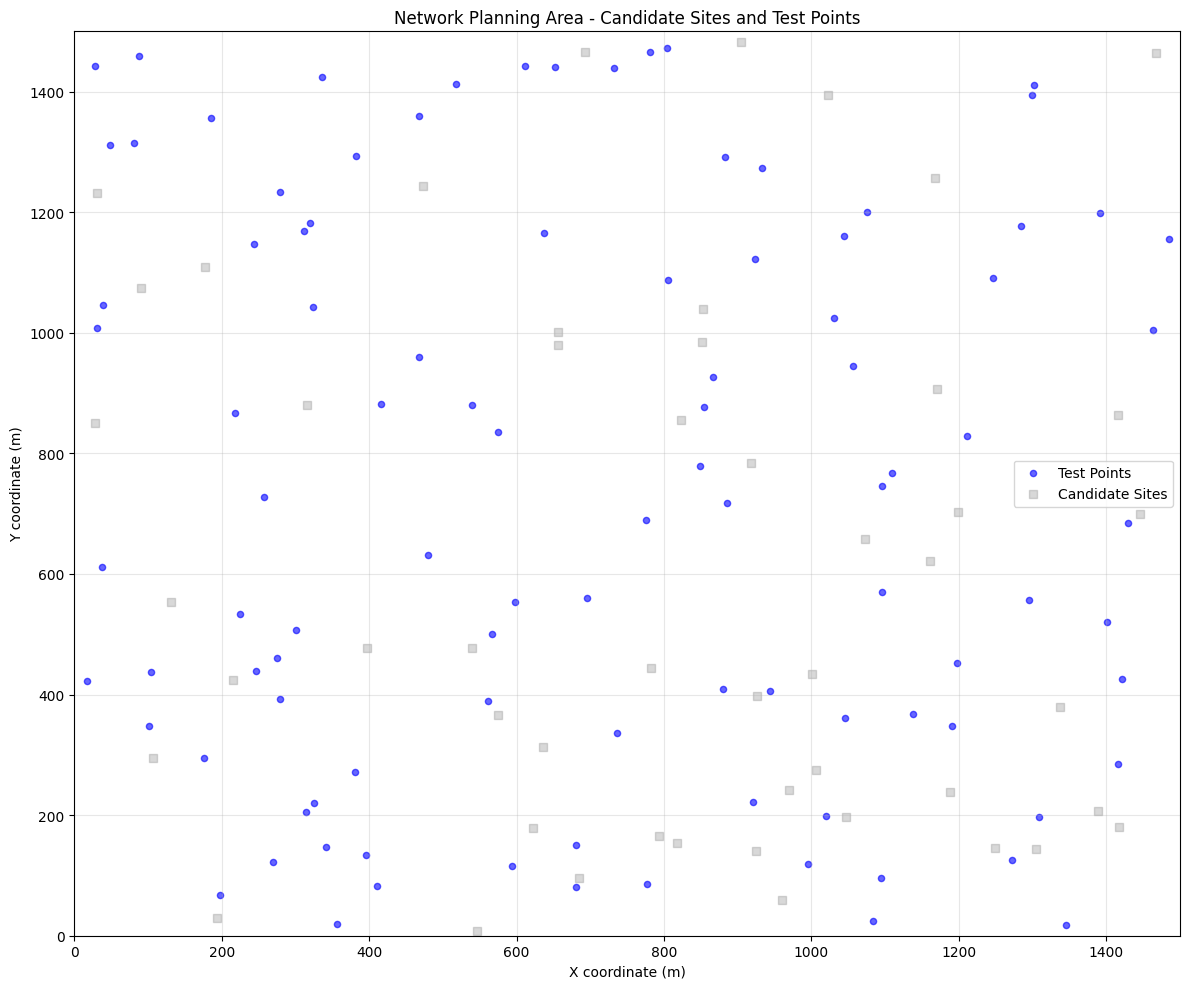

In [7]:
params = get_network_parameters()
topology = generate_topology(params)
p_r_macro, p_r_micro = calculate_received_powers(topology, params)

# Network topology visualization (matching results plot style)
plt.figure(figsize=(12, 10))

# Plot test points (matching results plot style)
plt.scatter(topology['tp_x_coords'], topology['tp_y_coords'],
           c='blue', s=20, alpha=0.6, label='Test Points')

# Plot candidate sites (matching results plot style)
plt.scatter(topology['cs_x_coords'], topology['cs_y_coords'],
           c='gray', s=30, alpha=0.3, marker='s', label='Candidate Sites')

plt.xlim(0, params['area_width'])
plt.ylim(0, params['area_height'])
plt.xlabel('X coordinate (m)')
plt.ylabel('Y coordinate (m)')
plt.title('Network Planning Area - Candidate Sites and Test Points')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Received Power Distribution Analysis**

If we were to activate every candidate site, this is the distribution
of signal strengths we'd get. The green line shows our coverage
threshold - we can see that many connections exceed this threshold,
confirming that our optimization problem is feasible.

Coverage analysis shows 35% of 5,000 potential connections exceed the -75 dBm threshold, validating problem feasibility with average received power of -76.46 dBm.

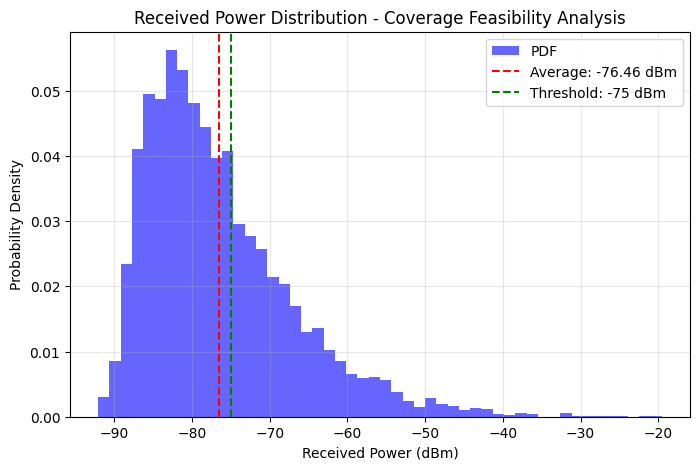


 COVERAGE FEASIBILITY ANALYSIS:
   • Total possible connections: 5,000
   • Viable connections (≥ -75 dBm): 1,751
   • Coverage feasibility: 35.0%
   • Average received power: -76.46 dBm


In [8]:
# Received Power Distribution Analysis
plt.figure(figsize=(8, 5))
plt.hist(p_r_macro.flatten(), bins=50, density=True, alpha=0.6, color='blue', label='PDF')
plt.axvline(np.mean(p_r_macro), color='red', linestyle='--', label=f'Average: {np.mean(p_r_macro):.2f} dBm')
plt.axvline(params['gamma'], color='green', linestyle='--', label=f'Threshold: {params["gamma"]} dBm')
plt.xlabel('Received Power (dBm)')
plt.ylabel('Probability Density')
plt.title('Received Power Distribution - Coverage Feasibility Analysis')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Analysis summary
total_connections = params['num_cs'] * params['num_tp']
viable_connections = np.sum(p_r_macro >= params['gamma'])
coverage_percentage = (viable_connections / total_connections) * 100

print(f"\n COVERAGE FEASIBILITY ANALYSIS:")
print(f"   • Total possible connections: {total_connections:,}")
print(f"   • Viable connections (≥ {params['gamma']} dBm): {viable_connections:,}")
print(f"   • Coverage feasibility: {coverage_percentage:.1f}%")
print(f"   • Average received power: {np.mean(p_r_macro):.2f} dBm")


In [9]:
def plot_network_layout(topology, install_solution, serve_solution, bs_type, title, params):
    """Plot the network layout with installed base stations and coverage."""
    plt.figure(figsize=(12, 10))

    # Plot test points
    plt.scatter(topology['tp_x_coords'], topology['tp_y_coords'], c='blue', s=20, alpha=0.6, label='Test Points')

    # Plot candidate sites
    plt.scatter(topology['cs_x_coords'], topology['cs_y_coords'], c='gray', s=30, alpha=0.3, marker='s', label='Candidate Sites')

    # Plot installed base stations
    if bs_type == 'mixed':
        # For mixed scenario, plot macro and micro separately with different markers
        macro_x = []
        macro_y = []
        micro_x = []
        micro_y = []

        for i in range(params['num_cs']):
            if install_solution.get((i, 'macro'), 0) > 0.5:
                macro_x.append(topology['cs_x_coords'][i])
                macro_y.append(topology['cs_y_coords'][i])
            elif install_solution.get((i, 'micro'), 0) > 0.5:
                micro_x.append(topology['cs_x_coords'][i])
                micro_y.append(topology['cs_y_coords'][i])

        # Plot macro stations as squares (cubes)
        if macro_x:
            plt.scatter(macro_x, macro_y, c='red', s=100, marker='s',
                       label='Installed Macro BS', edgecolors='black')

        # Plot micro stations as triangles
        if micro_x:
            plt.scatter(micro_x, micro_y, c='red', s=100, marker='^',
                       label='Installed Micro BS', edgecolors='black')

    elif bs_type == 'macro':
        # For macro-only scenario, use squares
        installed_x = []
        installed_y = []
        for i in range(params['num_cs']):
            if install_solution.get(i, 0) > 0.5:
                installed_x.append(topology['cs_x_coords'][i])
                installed_y.append(topology['cs_y_coords'][i])

        plt.scatter(installed_x, installed_y, c='red', s=100, marker='s',
                   label='Installed Macro BS', edgecolors='black')

    elif bs_type == 'micro':
        # For micro-only scenario, use triangles
        installed_x = []
        installed_y = []
        for i in range(params['num_cs']):
            if install_solution.get(i, 0) > 0.5:
                installed_x.append(topology['cs_x_coords'][i])
                installed_y.append(topology['cs_y_coords'][i])

        plt.scatter(installed_x, installed_y, c='red', s=100, marker='^',
                   label='Installed Micro BS', edgecolors='black')

    # Draw coverage lines
    if bs_type == 'mixed':
        for key, value in serve_solution.items():
            if value > 0.5:
                i, j, bs_t = key
                # Use different line colors for macro vs micro connections
                line_color = 'green'
                plt.plot([topology['cs_x_coords'][i], topology['tp_x_coords'][j]],
                        [topology['cs_y_coords'][i], topology['tp_y_coords'][j]],
                        color=line_color, alpha=0.3, linewidth=0.5)
    else:
        for key, value in serve_solution.items():
            if value > 0.5:
                i, j = key
                line_color = 'green'
                plt.plot([topology['cs_x_coords'][i], topology['tp_x_coords'][j]],
                        [topology['cs_y_coords'][i], topology['tp_y_coords'][j]],
                        color=line_color, alpha=0.3, linewidth=0.5)

    plt.xlim(0, params['area_width'])
    plt.ylim(0, params['area_height'])
    plt.xlabel('X coordinate (m)')
    plt.ylabel('Y coordinate (m)')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt.gcf()


In [10]:
def create_cost_comparison_charts(cost_macro, cost_micro, cost_mixed, deployment_stats):
    """
    Create professional cost comparison visualizations.

    Parameters:
    - cost_macro: float, cost of macro-only solution
    - cost_micro: float, cost of micro-only solution
    - cost_mixed: float, cost of mixed solution
    - deployment_stats: dict, deployment statistics from analyze_deployment_results()

    Returns:
    - pandas.DataFrame: comparison table
    """

    print("Creating cost comparison visualizations...")

    # 1. BAR CHART: Cost Comparison
    scenarios = ['Macro-only', 'Micro-only', 'Mixed']
    costs = [cost_macro, cost_micro, cost_mixed]
    colors = ['#87CEEB', '#4682B4', '#1e3a8a']  # Light Blue, Steel Blue, Dark Blue

    plt.figure(figsize=(7, 4))
    bars = plt.bar(scenarios, costs, color=colors, alpha=0.8, edgecolor='black')

    # Add value labels on bars
    for bar, cost in zip(bars, costs):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'${cost:.2f}', ha='center', va='bottom', fontweight='bold')

    plt.ylabel('Total Cost ($)')
    plt.title('Network Deployment Cost Comparison', fontsize=14, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 2. DETAILED COMPARISON TABLE
    comparison_data = {
        'Scenario': ['Macro-only', 'Micro-only', 'Mixed'],
        'Total Cost ($)': [f'{cost_macro:.2f}', f'{cost_micro:.2f}', f'{cost_mixed:.2f}'],
        'Total Base Stations': [
            deployment_stats['macro_only']['total'],
            deployment_stats['micro_only']['total'],
            deployment_stats['mixed']['total']
        ],
        'Macro Stations': [
            deployment_stats['macro_only']['macro'],
            deployment_stats['micro_only']['macro'],
            deployment_stats['mixed']['macro']
        ],
        'Micro Stations': [
            deployment_stats['macro_only']['micro'],
            deployment_stats['micro_only']['micro'],
            deployment_stats['mixed']['micro']
        ],
        'Cost vs Best (%)': [
            f'+{((cost_macro/min(costs) - 1) * 100):.1f}%',
            f'+{((cost_micro/min(costs) - 1) * 100):.1f}%',
            f'+{((cost_mixed/min(costs) - 1) * 100):.1f}%'
        ]
    }

    df = pd.DataFrame(comparison_data)

    # Create a visual table instead of text output
    fig, ax = plt.subplots(figsize=(8, 2.5))
    ax.axis('tight')
    ax.axis('off')

    # Create table
    table = ax.table(cellText=df.values, colLabels=df.columns,
                    cellLoc='center', loc='center',
                    colColours=['#E6F3FF']*len(df.columns))

    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.1, 1.8)

    # Color the rows with alternating blue shades
    for i in range(len(df)):
        for j in range(len(df.columns)):
            if i % 2 == 0:
                table[(i+1, j)].set_facecolor('#F0F8FF')  # Alice blue
            else:
                table[(i+1, j)].set_facecolor('#E6F3FF')  # Light blue

    plt.title('Detailed Cost and Deployment Comparison', fontsize=12, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

    # 3. SAVINGS ANALYSIS CHART
    best_cost = min(costs)

    if cost_mixed < min(cost_macro, cost_micro):
        single_best = min(cost_macro, cost_micro)
        mixed_savings = single_best - cost_mixed

        plt.figure(figsize=(7, 4))

        # Savings bar chart
        categories = ['Mixed vs\nMacro-only', 'Mixed vs\nMicro-only', 'Mixed vs\nBest Single']
        savings = [cost_macro - cost_mixed, cost_micro - cost_mixed, mixed_savings]

        bars = plt.bar(categories, savings, color=['#87CEEB', '#4682B4', '#1e3a8a'],
                      alpha=0.8, edgecolor='black')

        # Add value labels
        for bar, saving in zip(bars, savings):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'${saving:.2f}', ha='center', va='bottom', fontweight='bold')

        plt.ylabel('Cost Savings ($)')
        plt.title('Mixed Deployment Savings Analysis', fontsize=14, fontweight='bold')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Savings percentage
        savings_pct = (mixed_savings / single_best) * 100
        print(f"\n KEY INSIGHT: Mixed deployment saves ${mixed_savings:.2f} ({savings_pct:.1f}%) vs best single-type solution")

    # 4. BASE STATION COUNT COMPARISON
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))

    # Total base stations
    totals = [deployment_stats[key]['total'] for key in ['macro_only', 'micro_only', 'mixed']]
    bars1 = ax1.bar(scenarios, totals, color=colors, alpha=0.8, edgecolor='black')

    for bar, total in zip(bars1, totals):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                str(total), ha='center', va='bottom', fontweight='bold')

    ax1.set_ylabel('Number of Base Stations')
    ax1.set_title('Total Base Stations Required')
    ax1.grid(axis='y', alpha=0.3)

    # Stacked bar chart for macro vs micro breakdown
    macro_counts = [deployment_stats[key]['macro'] for key in ['macro_only', 'micro_only', 'mixed']]
    micro_counts = [deployment_stats[key]['micro'] for key in ['macro_only', 'micro_only', 'mixed']]

    ax2.bar(scenarios, macro_counts, label='Macro BS', color='#87CEEB', alpha=0.8)
    ax2.bar(scenarios, micro_counts, bottom=macro_counts, label='Micro BS',
           color='#1e3a8a', alpha=0.8)

    ax2.set_ylabel('Number of Base Stations')
    ax2.set_title('Base Station Type Breakdown')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    return df

## Solver Functions

3 solver function for the 3 modes:
- Marco Only
- Micro Only
- Mixed

In [11]:
def solve_macro_only(topology, p_r_macro, thr_macro, params):
    """Solve optimization problem using only macro base stations."""
    ampl = AMPL()

    # Model formulation
    ampl.eval('''
    # Sets
    set CS;  # Candidate sites
    set TP;  # Test points

    # Parameters
    param cost{CS};  # Installation cost for each candidate site
    param coverage{CS, TP} binary;  # Coverage matrix (1 if CS can cover TP)
    param throughput{CS, TP};  # Throughput from CS to TP
    param min_thr;  # Minimum throughput requirement

    # Decision Variables
    var install{CS} binary;  # 1 if BS is installed at candidate site
    var serve{CS, TP} binary;  # 1 if CS serves TP

    # Objective: Minimize total installation cost
    minimize Total_Cost: sum{i in CS} cost[i] * install[i];

    # Constraints
    # Each test point must be served one or more than one base station
    subject to Coverage{j in TP}:
        sum{i in CS} serve[i,j] >= 1;

    # Can only serve if base station is installed
    subject to Installation{i in CS, j in TP}:
        serve[i,j] <= install[i];

    # Coverage constraint: can only serve if coverage is available
    subject to Coverage_Limit{i in CS, j in TP}:
        serve[i,j] <= coverage[i,j];

    # Throughput constraint
    subject to Throughput_Requirement{j in TP}:
        sum{i in CS} throughput[i,j] * serve[i,j] >= min_thr;
    ''')

    # Set data
    ampl.set['CS'] = range(params['num_cs'])
    ampl.set['TP'] = range(params['num_tp'])

    # Cost parameters
    cost_dict = {i: topology['installation_costs_macro'][i] for i in range(params['num_cs'])}
    ampl.param['cost'] = cost_dict

    # Coverage matrix (1 if received power > sensitivity)
    coverage_dict = {}
    for i in range(params['num_cs']):
        for j in range(params['num_tp']):
            coverage_dict[i, j] = 1 if p_r_macro[i, j] >= params['gamma'] else 0
    ampl.param['coverage'] = coverage_dict

    # Throughput matrix
    throughput_dict = {}
    for i in range(params['num_cs']):
        for j in range(params['num_tp']):
            throughput_dict[i, j] = thr_macro[i, j]
    ampl.param['throughput'] = throughput_dict

    ampl.param['min_thr'] = params['min_bitrate']

    # Solve
    ampl.option['solver'] = 'highs'
    ampl.solve()

    # Get results
    install_macro = ampl.var['install'].to_dict()
    serve_macro = ampl.var['serve'].to_dict()
    cost_macro = ampl.obj['Total_Cost'].value()

    ampl.close()
    return install_macro, serve_macro, cost_macro


In [12]:
def solve_micro_only(topology, p_r_micro, thr_micro, params):
    """Solve optimization problem using only micro base stations."""
    ampl = AMPL()

    # Same model as macro
    ampl.eval('''
    # Sets
    set CS;  # Candidate sites
    set TP;  # Test points

    # Parameters
    param cost{CS};  # Installation cost for each candidate site
    param coverage{CS, TP} binary;  # Coverage matrix (1 if CS can cover TP)
    param throughput{CS, TP};  # Throughput from CS to TP
    param min_thr;  # Minimum throughput requirement

    # Decision Variables
    var install{CS} binary;  # 1 if BS is installed at candidate site
    var serve{CS, TP} binary;  # 1 if CS serves TP

    # Objective: Minimize total installation cost
    minimize Total_Cost: sum{i in CS} cost[i] * install[i];

    # Constraints
    # Each test point must be served one or more than one base station
    subject to Coverage{j in TP}:
        sum{i in CS} serve[i,j] >= 1;

    subject to Installation{i in CS, j in TP}:
        serve[i,j] <= install[i];

    subject to Coverage_Limit{i in CS, j in TP}:
        serve[i,j] <= coverage[i,j];

    subject to Throughput_Requirement{j in TP}:
        sum{i in CS} throughput[i,j] * serve[i,j] >= min_thr;
    ''')

    # Set data
    ampl.set['CS'] = range(params['num_cs'])
    ampl.set['TP'] = range(params['num_tp'])

    # Cost parameters
    cost_dict = {i: topology['installation_costs_micro'][i] for i in range(params['num_cs'])}
    ampl.param['cost'] = cost_dict

    # Coverage matrix
    coverage_dict = {}
    for i in range(params['num_cs']):
        for j in range(params['num_tp']):
            coverage_dict[i, j] = 1 if p_r_micro[i, j] >= params['gamma'] else 0
    ampl.param['coverage'] = coverage_dict

    # Throughput matrix
    throughput_dict = {}
    for i in range(params['num_cs']):
        for j in range(params['num_tp']):
            throughput_dict[i, j] = thr_micro[i, j]
    ampl.param['throughput'] = throughput_dict

    ampl.param['min_thr'] = params['min_bitrate']

    # Solve
    ampl.option['solver'] = 'highs'
    ampl.solve()

    # Get results
    install_micro = ampl.var['install'].to_dict()
    serve_micro = ampl.var['serve'].to_dict()
    cost_micro = ampl.obj['Total_Cost'].value()

    ampl.close()
    return install_micro, serve_micro, cost_micro


In [13]:
def solve_mixed(topology, p_r_macro, p_r_micro, thr_macro, thr_micro, params):
    """Solve optimization problem using both macro and micro base stations."""
    ampl = AMPL()

    # Extended model with two BS types
    ampl.eval('''
    # Sets
    set CS;  # Candidate sites
    set TP;  # Test points
    set BS_TYPE;  # Base station types {macro, micro}

    # Parameters
    param cost{CS, BS_TYPE};  # Installation cost
    param coverage{CS, TP, BS_TYPE} binary;  # Coverage matrix
    param throughput{CS, TP, BS_TYPE};  # Throughput matrix
    param min_thr;  # Minimum throughput requirement

    # Decision Variables
    var install{CS, BS_TYPE} binary;  # 1 if BS of type is installed at CS
    var serve{CS, TP, BS_TYPE} binary;  # 1 if CS with BS type serves TP

    # Objective: Minimize total installation cost
    minimize Total_Cost: sum{i in CS, t in BS_TYPE} cost[i,t] * install[i,t];

    # Constraints
    # Each test point must be served one or more than one base station
    subject to Coverage{j in TP}:
        sum{i in CS, t in BS_TYPE} serve[i,j,t] >= 1;

    # Can only serve if base station is installed
    subject to Installation{i in CS, j in TP, t in BS_TYPE}:
        serve[i,j,t] <= install[i,t];

    # Only one type of BS can be installed per candidate site
    subject to Single_Type{i in CS}:
        sum{t in BS_TYPE} install[i,t] <= 1;

    # Coverage constraint
    subject to Coverage_Limit{i in CS, j in TP, t in BS_TYPE}:
        serve[i,j,t] <= coverage[i,j,t];

    # Throughput constraint
    subject to Throughput_Requirement{j in TP}:
        sum{i in CS, t in BS_TYPE} throughput[i,j,t] * serve[i,j,t] >= min_thr;
    ''')

    # Set data
    ampl.set['CS'] = range(params['num_cs'])
    ampl.set['TP'] = range(params['num_tp'])
    ampl.set['BS_TYPE'] = ['macro', 'micro']

    # Cost parameters
    cost_dict = {}
    for i in range(params['num_cs']):
        cost_dict[i, 'macro'] = topology['installation_costs_macro'][i]
        cost_dict[i, 'micro'] = topology['installation_costs_micro'][i]
    ampl.param['cost'] = cost_dict

    # Coverage matrices
    coverage_dict = {}
    for i in range(params['num_cs']):
        for j in range(params['num_tp']):
            coverage_dict[i, j, 'macro'] = 1 if p_r_macro[i, j] >= params['gamma'] else 0
            coverage_dict[i, j, 'micro'] = 1 if p_r_micro[i, j] >= params['gamma'] else 0
    ampl.param['coverage'] = coverage_dict

    # Throughput matrices
    throughput_dict = {}
    for i in range(params['num_cs']):
        for j in range(params['num_tp']):
            throughput_dict[i, j, 'macro'] = thr_macro[i, j]
            throughput_dict[i, j, 'micro'] = thr_micro[i, j]
    ampl.param['throughput'] = throughput_dict

    ampl.param['min_thr'] = params['min_bitrate']

    # Solve
    ampl.option['solver'] = 'highs'
    ampl.solve()

    # Get results
    install_mixed = ampl.var['install'].to_dict()
    serve_mixed = ampl.var['serve'].to_dict()
    cost_mixed = ampl.obj['Total_Cost'].value()

    ampl.close()
    return install_mixed, serve_mixed, cost_mixed


## Getting Resutls

In [14]:
# cost ratios, we can change this ratio to see the impact of cost ratio on the final result.
#Smaller cost ratio leads us toward using more macro base stations as they have stronger signal strength
cost_ratios = [5]

for ratio in cost_ratios:
    print(f"\n{'='*60}")
    print(f"TESTING COST RATIO {ratio}:1 (Macro:Micro)")
    print(f"{'='*60}")

    # Get parameters with current cost ratio
    params = get_network_parameters()
    params['cost_ratio'] = ratio  # Set the current ratio

    topology = generate_topology(params)
    p_r_macro, p_r_micro = calculate_received_powers(topology, params)
    thr_macro, thr_micro = calculate_throughputs(p_r_macro, p_r_micro, params)


TESTING COST RATIO 5:1 (Macro:Micro)


In [15]:
# Solve macro-only scenario
print("Solving macro-only scenario...")
try:
    install_macro, serve_macro, cost_macro = solve_macro_only(topology, p_r_macro, thr_macro, params)
    print(f"Macro-only cost: ${cost_macro:.2f}")
except Exception as e:
    print(f"Macro-only optimization failed: {e}")
    cost_macro = float('inf')
    install_macro, serve_macro = {}, {}

Solving macro-only scenario...
HiGHS 1.11.0: HiGHS 1.11.0: optimal solution; objective 9.24132643
1228 simplex iterations
1 branching nodes
Macro-only cost: $9.24


In [16]:
# Solve micro-only scenario
print("Solving micro-only scenario...")
try:
    install_micro, serve_micro, cost_micro = solve_micro_only(topology, p_r_micro, thr_micro, params)
    print(f"Micro-only cost: ${cost_micro:.2f}")
except Exception as e:
    print(f"Micro-only optimization failed: {e}")
    cost_micro = float('inf')
    install_micro, serve_micro = {}, {}

Solving micro-only scenario...
HiGHS 1.11.0: HiGHS 1.11.0: optimal solution; objective 7.321279412
367 simplex iterations
1 branching nodes
Micro-only cost: $7.32


In [17]:
# Solve mixed scenario
print("Solving mixed scenario...")
try:
    install_mixed, serve_mixed, cost_mixed = solve_mixed(topology, p_r_macro, p_r_micro, thr_macro, thr_micro, params)
    print(f"Mixed cost: ${cost_mixed:.2f}")
except Exception as e:
    print(f"Mixed optimization failed: {e}")
    cost_mixed = float('inf')
    install_mixed, serve_mixed = {}, {}

Solving mixed scenario...
HiGHS 1.11.0: HiGHS 1.11.0: optimal solution; objective 6.766527785
43 simplex iterations
1 branching nodes
Mixed cost: $6.77


In [18]:
# Analysis
print(f"\nResults Summary for cost ratio {ratio}:1:")
print(f"Macro-only cost: ${cost_macro:.2f}")
print(f"Micro-only cost: ${cost_micro:.2f}")
print(f"Mixed cost: ${cost_mixed:.2f}")

if cost_macro < cost_micro:
    print("\nRecommendation: Use macro base stations only")
    best_single = "macro"
else:
    print("\nRecommendation: Use micro base stations only")
    best_single = "micro"

if cost_mixed < min(cost_macro, cost_micro):
    savings = min(cost_macro, cost_micro) - cost_mixed
    savings_pct = (savings / min(cost_macro, cost_micro)) * 100
    print(f"Mixed deployment saves: ${savings:.2f} ({savings_pct:.1f}%)")
else:
    print("Mixed deployment does not provide cost savings")


Results Summary for cost ratio 5:1:
Macro-only cost: $9.24
Micro-only cost: $7.32
Mixed cost: $6.77

Recommendation: Use micro base stations only
Mixed deployment saves: $0.55 (7.6%)


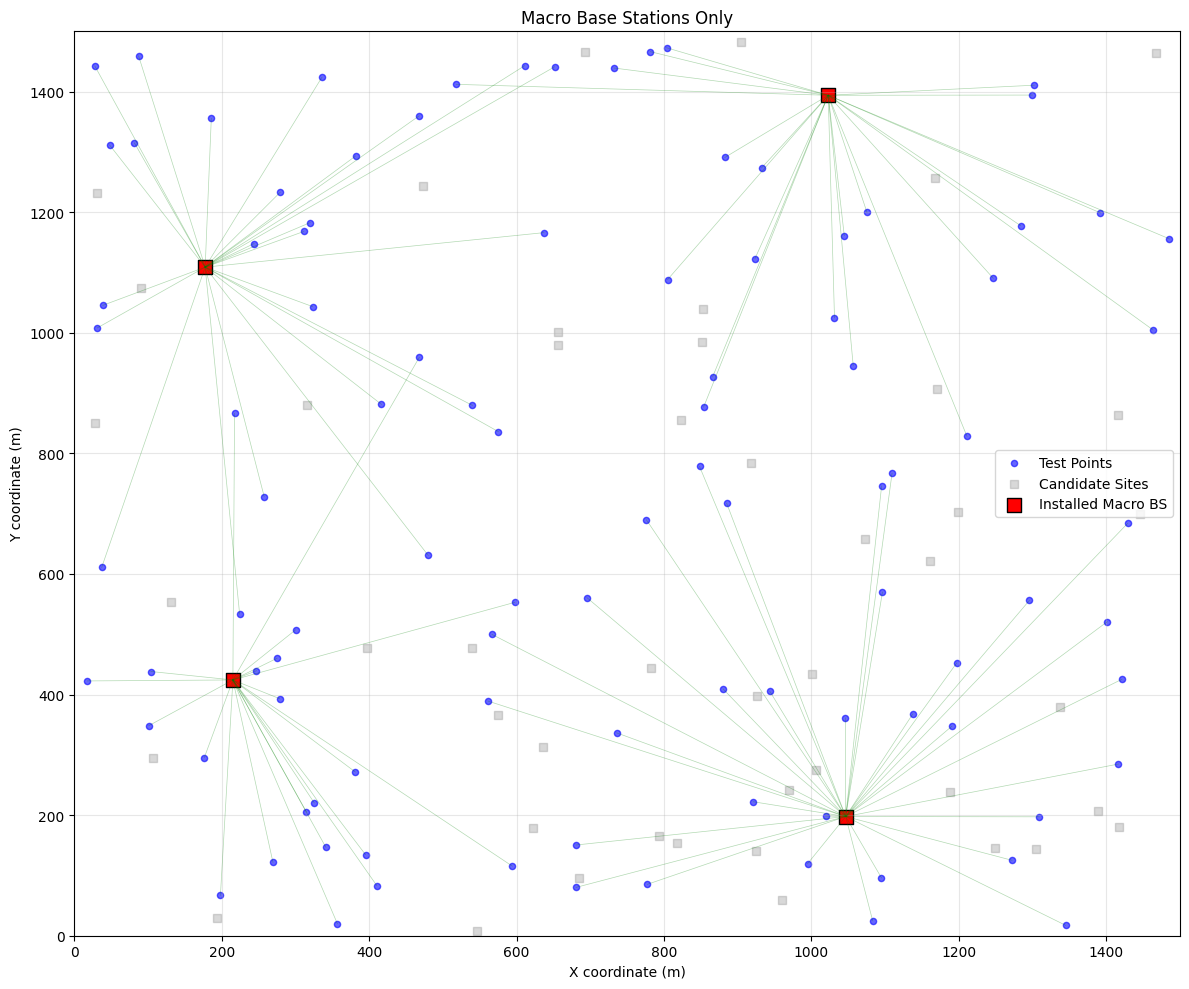

In [19]:
# Generate plots
if cost_macro != float('inf'):
    fig1 = plot_network_layout(topology, install_macro, serve_macro, 'macro', 'Macro Base Stations Only', params)
    plt.savefig('macro_layout_functions.png', dpi=300, bbox_inches='tight')
    plt.show()


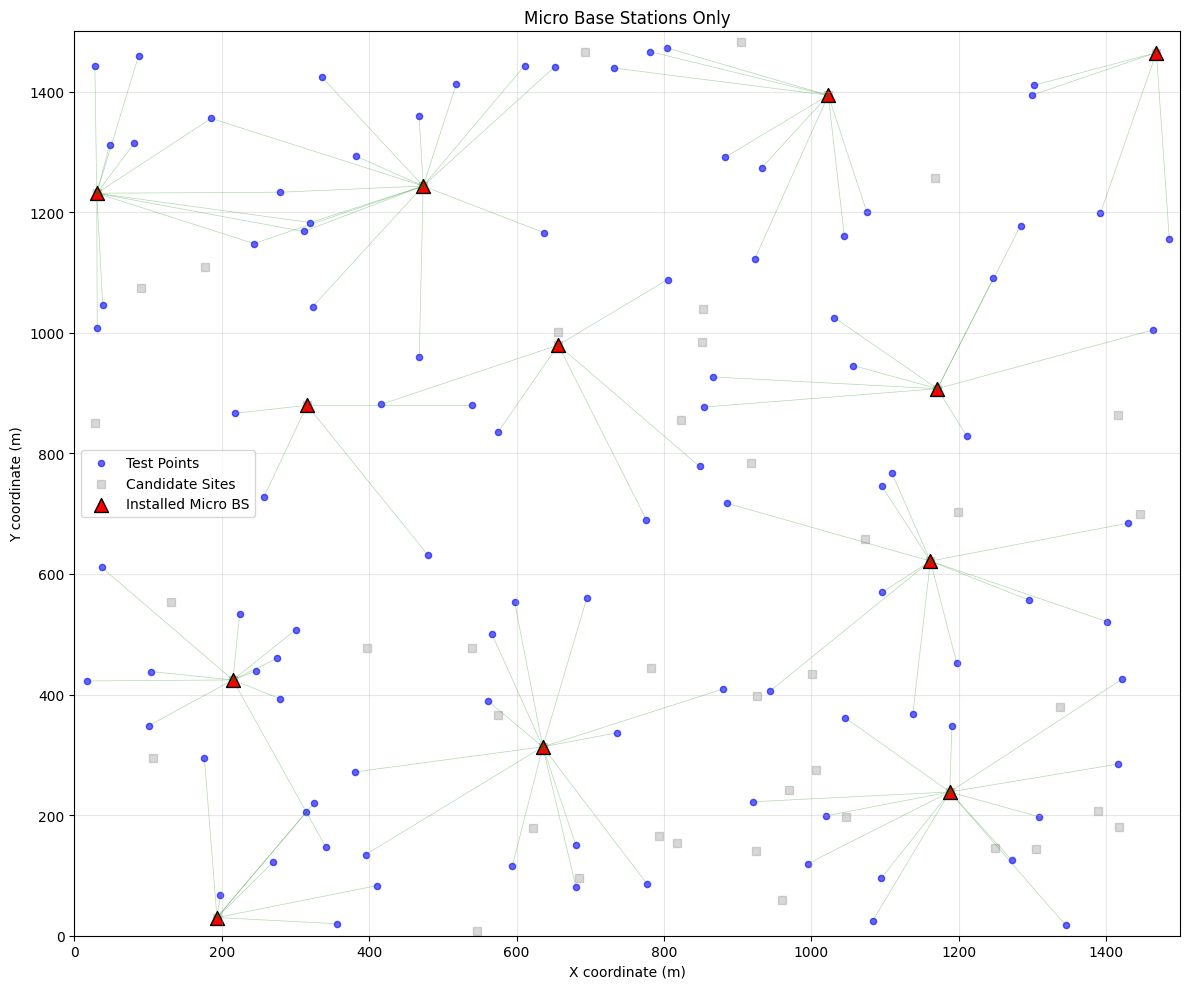

In [20]:
if cost_micro != float('inf'):
    fig2 = plot_network_layout(topology, install_micro, serve_micro, 'micro', 'Micro Base Stations Only', params)
    plt.savefig('micro_layout_functions.png', dpi=300, bbox_inches='tight')
    plt.show()

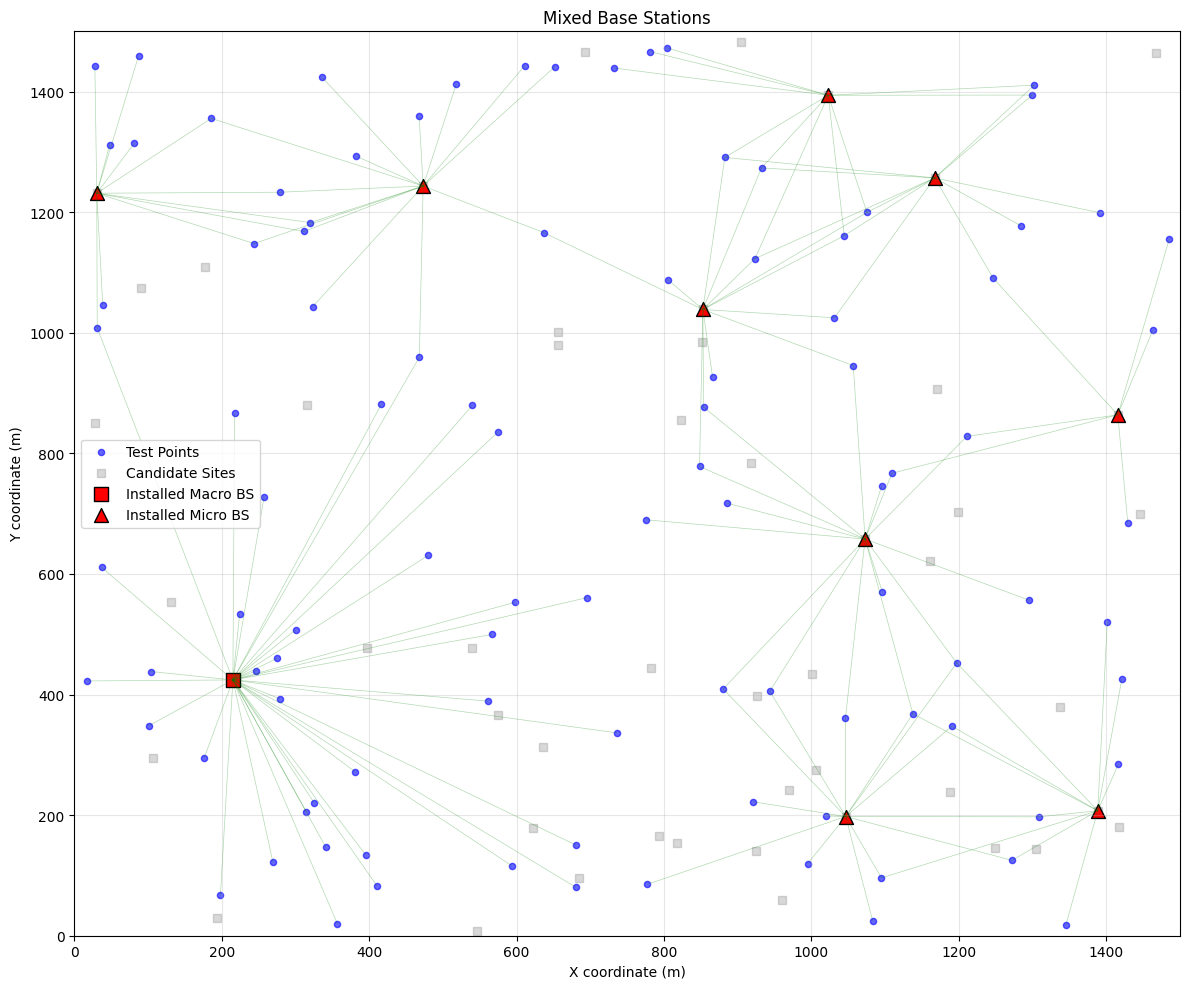

In [21]:
if cost_mixed != float('inf'):
    fig3 = plot_network_layout(topology, install_mixed, serve_mixed, 'mixed', 'Mixed Base Stations', params)
    plt.savefig('mixed_layout_functions.png', dpi=300, bbox_inches='tight')
    plt.show()

In [22]:
# Analyze base station deployment in each scenario

def analyze_deployment_results(install_macro, install_micro, install_mixed, params):
    """
    Analyze the number of base stations deployed in each scenario
    """
    print("="*60)
    print("BASE STATION DEPLOYMENT ANALYSIS")
    print("="*60)

    # Scenario 1: Macro-only analysis
    print("\n1. MACRO-ONLY SCENARIO:")
    print("-" * 30)
    macro_count = 0
    macro_sites = []

    for i in range(params['num_cs']):
        if install_macro.get(i, 0) > 0.5:  # Check if macro BS is installed
            macro_count += 1
            macro_sites.append(i)

    print(f"Total Base Stations: {macro_count}")
    print(f"  - Macro stations: {macro_count}")
    print(f"  - Micro stations: 0")
    print(f"Installed at candidate sites: {macro_sites}")

    # Scenario 2: Micro-only analysis
    print("\n2. MICRO-ONLY SCENARIO:")
    print("-" * 30)
    micro_count = 0
    micro_sites = []

    for i in range(params['num_cs']):
        if install_micro.get(i, 0) > 0.5:  # Check if micro BS is installed
            micro_count += 1
            micro_sites.append(i)

    print(f"Total Base Stations: {micro_count}")
    print(f"  - Macro stations: 0")
    print(f"  - Micro stations: {micro_count}")
    print(f"Installed at candidate sites: {micro_sites}")

    # Scenario 3: Mixed analysis
    print("\n3. MIXED SCENARIO:")
    print("-" * 30)
    mixed_macro_count = 0
    mixed_micro_count = 0
    mixed_macro_sites = []
    mixed_micro_sites = []

    for i in range(params['num_cs']):
        # Check for macro installations
        if install_mixed.get((i, 'macro'), 0) > 0.5:
            mixed_macro_count += 1
            mixed_macro_sites.append(i)

        # Check for micro installations
        if install_mixed.get((i, 'micro'), 0) > 0.5:
            mixed_micro_count += 1
            mixed_micro_sites.append(i)

    total_mixed = mixed_macro_count + mixed_micro_count

    print(f"Total Base Stations: {total_mixed}")
    print(f"  - Macro stations: {mixed_macro_count}")
    print(f"  - Micro stations: {mixed_micro_count}")

    if mixed_macro_sites:
        print(f"Macro stations at sites: {mixed_macro_sites}")
    if mixed_micro_sites:
        print(f"Micro stations at sites: {mixed_micro_sites}")



    return {
        'macro_only': {'total': macro_count, 'macro': macro_count, 'micro': 0, 'sites': macro_sites},
        'micro_only': {'total': micro_count, 'macro': 0, 'micro': micro_count, 'sites': micro_sites},
        'mixed': {'total': total_mixed, 'macro': mixed_macro_count, 'micro': mixed_micro_count,
                 'macro_sites': mixed_macro_sites, 'micro_sites': mixed_micro_sites}
    }


print("\nDETAILED ANALYSIS:")
deployment_stats = analyze_deployment_results(install_macro, install_micro, install_mixed, params)



DETAILED ANALYSIS:
BASE STATION DEPLOYMENT ANALYSIS

1. MACRO-ONLY SCENARIO:
------------------------------
Total Base Stations: 4
  - Macro stations: 4
  - Micro stations: 0
Installed at candidate sites: [24, 26, 39, 42]

2. MICRO-ONLY SCENARIO:
------------------------------
Total Base Stations: 12
  - Macro stations: 0
  - Micro stations: 12
Installed at candidate sites: [4, 6, 10, 16, 20, 23, 26, 31, 39, 46, 47, 48]

3. MIXED SCENARIO:
------------------------------
Total Base Stations: 10
  - Macro stations: 1
  - Micro stations: 9
Macro stations at sites: [26]
Micro stations at sites: [1, 13, 16, 18, 33, 38, 39, 42, 48]


CREATING COST ANALYSIS...
Creating cost comparison visualizations...


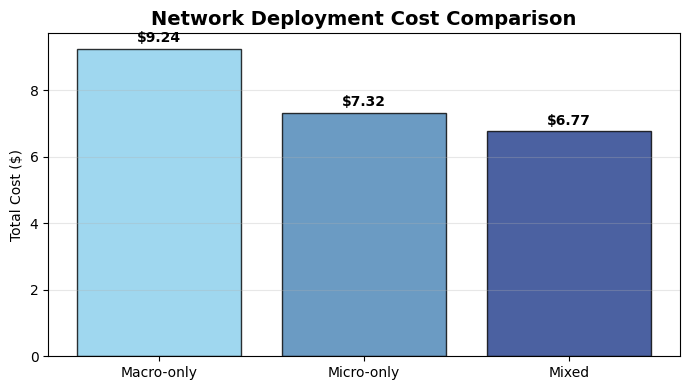

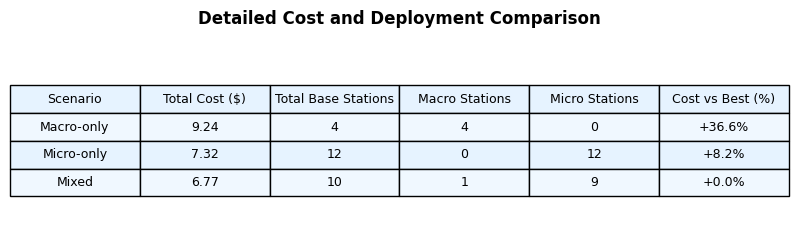

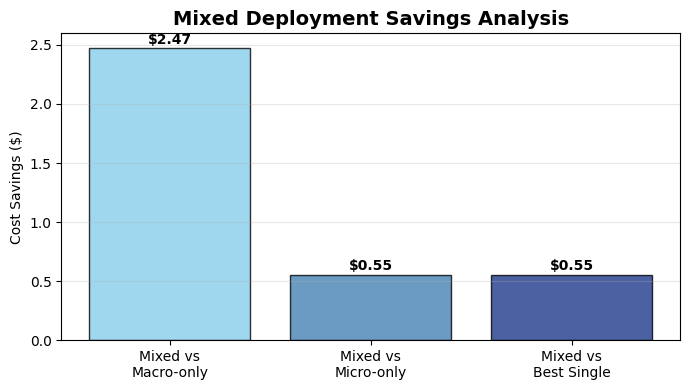


 KEY INSIGHT: Mixed deployment saves $0.55 (7.6%) vs best single-type solution


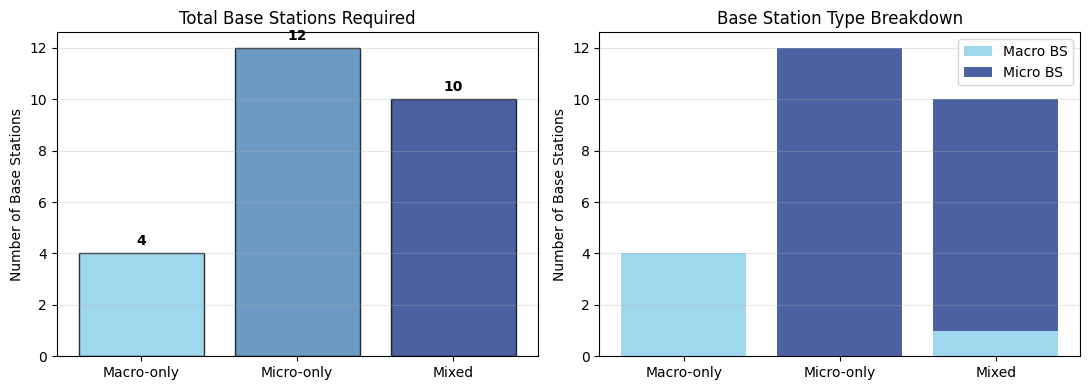

In [23]:
# COST ANALYSIS
print("CREATING COST ANALYSIS...")

# Create visual charts and tables
comparison_df = create_cost_comparison_charts(
    cost_macro=cost_macro,
    cost_micro=cost_micro,
    cost_mixed=cost_mixed,
    deployment_stats=deployment_stats
)